## Dev

In [1]:
%pip install -qU langchain-community langgraph langgraph-checkpoint-sqlite langchain-openai langchain-groq langchain_mistralai

Note: you may need to restart the kernel to use updated packages.


### LangGraph

In [44]:
from typing import Annotated, Literal, Sequence, List, Any, Dict
from typing_extensions import TypedDict
from pprint import pprint

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.callbacks.base import BaseCallbackHandler

from pydantic import BaseModel, Field

import sys
sys.path.insert(1, '../DefAgent')

import src.prompts as prompts
import src.utils as utils
import src.tools as tools
import src.models as models
import src.retriever as retriever

ModuleNotFoundError: No module named 'src.prompts'

In [36]:
class CustomHandler(BaseCallbackHandler):
    def on_llm_start(
        self, serialized: Dict[str, Any], prompts: List[str], **kwargs: Any
    ) -> Any:
        formatted_prompts = "\n".join(prompts)
        print(f"-> PROMPT:\n{formatted_prompts}\n")


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    input_query: str
    messages: Annotated[Sequence[BaseMessage], add_messages]


class DefAgent:
    def __init__(self, model):
        self.model = model
        self.vectorstore = retriever.setup_vectorstore()
        self.retriever_tool = tools.create_vector_search_tool(self.vectorstore)
        self.tools = [self.retriever_tool]
        self.workflow = self.setup_workflow()

    def agent(self, state):
        """
        Invokes the agent model to generate a response based on the current state. Given
        the question, it will decide to retrieve using the retriever tool, or simply end.

        Args:
            state (messages): The current state

        Returns:
            dict: The updated state with the agent response appended to messages
        """
        print("---QURY AGENT---")
        model = self.model.bind_tools(self.tools)
        input_query = state["input_query"]
        messages = state["messages"]
        response = model.invoke(messages, config={"callbacks": [CustomHandler()]})
        return {"messages": [response], "input_query": input_query}
    

    def filter_definitions(self, state) -> Literal["generate"]:
        """
        Filters the retrieved definitions based on their relevance to the question.

        Args:
            state (messages): The current state

        Returns:
            List[dict]: A list of dictionaries containing the relevant definitions and their metadata.
        """

        print("---FILTER DEFINITIONS---")

        class DefinitionMetadata(BaseModel):
            id: int = Field(description="the unique identifier of the definition")
            dataset: str = Field(description="the dataset the definition is from")
            document_id: str = Field(description="the document id the definition is from")
            references: List[str] = Field(description="the references mentioned the definition.")

        class Definition(BaseModel):
            metadata: DefinitionMetadata
            definition_text: str = Field(description="the full text of the definition")  # Changed from 'definition'

        class DefinitionsList(BaseModel):
            relevant_definitions: List[Definition] = Field(description="a list of relevant definitions")

        parser = PydanticOutputParser(pydantic_object=DefinitionsList)

        prompt = PromptTemplate(
            template="""
            You are a legal expert assessing the relevance of legal definitions to a user question. \n 
            Your job is to filter the list of definitions provided to you keeping only the relevant ones. \n
            If the definition contains keyword(s) or semantic meaning related to the user's question, keep it.\n
            Output only the relevant definitions using the formatting instructions provided. \n
            Here are the formatting instructions: {format_instructions} \n
            Here are the retrieved definitions, one for each line: \n {context} \n
            Here is the user question: {question} \n
            """,
            input_variables=["context", "question"],
            partial_variables={"format_instructions": parser.get_format_instructions()}
        )

        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        chain = prompt | self.model

        messages = state["messages"]
        last_message = messages[-1]

        question = state["input_query"]
        docs = last_message.content

        response = chain.invoke({"question": question, "context": docs}, config={"callbacks": [CustomHandler()]})

        return {"messages": [response]}


    def generate(self, state):
        """
        Generate definition

        Args:
            state (messages): The current state

        Returns:
            str: A legal definition
        """
        print("---GENERATE---")
        messages = state["messages"]
        question = state["input_query"]
        last_message = messages[-1]

        docs = last_message.content

        prompt = PromptTemplate(
            template="""
            You are a legal assistant for the task of generating legal definitions. \n
            Use the following retrieved definitions as context to answer the question. \n
            If you don't know the answer, just say that you don't know. \n
            Keep the answer concise and straight to the point, giving only the definition.
            Question: {question} \n
            Context: {context} \n
            Answer:
            """,
            input_variables=["context", "question"]
        )

        llm = self.model

        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        rag_chain = prompt | llm | StrOutputParser()

        response = rag_chain.invoke({"context": docs, "question": question}, config={"callbacks": [CustomHandler()]})
        return {"messages": [response]}
    

    def eurlex_agent(self, state):
        raise NotImplementedError

    def normattiva_agent(self, state):
        raise NotImplementedError

    def pdl_agent(self, state):
        raise NotImplementedError

    def setup_workflow(self):
        workflow = StateGraph(AgentState)

        workflow.add_node("agent", self.agent)  # agent
        workflow.add_node("retrieve", ToolNode([self.retriever_tool]))  # retrieval
        workflow.add_node("filter", self.filter_definitions)  # retrieval
        workflow.add_node("generate", self.generate)  # Generating a response after we know the documents are relevant
        #workflow.add_node("RefResolver", self.resolve_references)
        #workflow.add_node("EurLex agent", self.eurlex_agent)
        #workflow.add_node("Normattiva agent", self.normattiva_agent)
        #workflow.add_node("PDL agent", self.pdl_agent)


        workflow.add_edge(START, "agent")

        # Decide whether to retrieve
        workflow.add_conditional_edges(
            "agent",
            # Assess agent decision
            tools_condition,
            {
                # Translate the condition outputs to nodes in our graph
                "tools": "retrieve",
                END: END,
            },
        )

        workflow.add_edge("retrieve", "filter")
        #workflow.add_edge("filter", "RefResolver")
        workflow.add_edge("filter", "generate")
        #workflow.add_edge("generate", "EurLex agent")
        #workflow.add_edge("generate", "Normattiva agent")
        #workflow.add_edge("generate", "PDL agent")
        #workflow.add_edge("EurLex agent", END)
        #workflow.add_edge("Normattiva agent", END)
        #workflow.add_edge("PDL agent", END)
        workflow.add_edge("generate", END)

        self.graph = workflow.compile()

        return workflow
    
    def invoke(self, query):
        inputs = {
            "input_query": query,
            "messages": [
                ("system", ''),
                ("user", query),
            ]
        }

        for output in self.graph.stream(inputs):
            for key, value in output.items():
                print(f"<- OUTPUT from node '{key}':\n")
                print(value['messages'][-1])#, indent=2, width=80, depth=None)
            print("\n---\n")

model = models.groq
defagent = DefAgent(model)

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

---

## Use

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

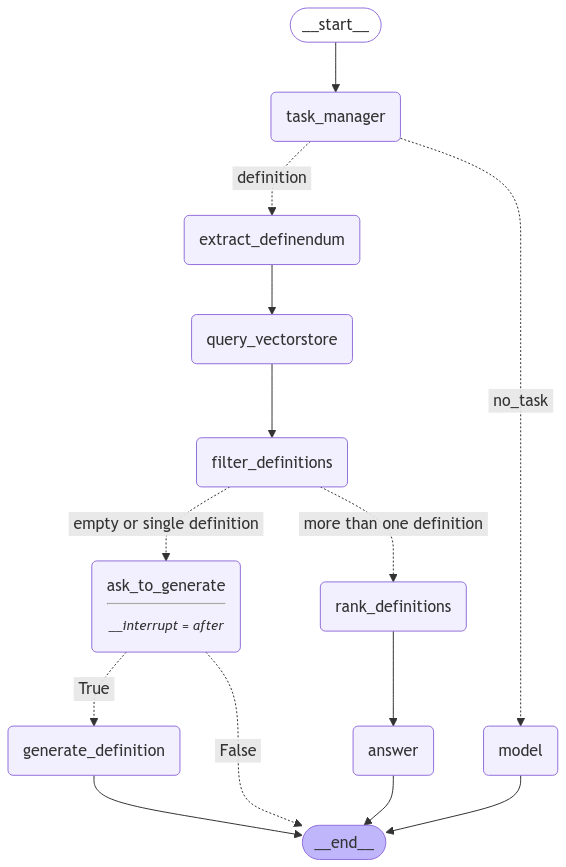

In [1]:
from LegalDefAgent.src.agent import LegalDefAgent
from LegalDefAgent.src.models import _get_model
from LegalDefAgent.src import utils

groq = _get_model('groq', streaming=True)
defagent = LegalDefAgent(model=groq, milvusdb_uri="/home/leo/Desktop/dhdk/Master thesis/.project/LegalDefAgent/app/vec_db/definitions_vector.db")

graph = defagent.graph_runnable

utils.draw_graph(graph)

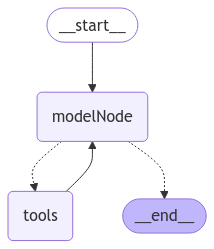

Thread ID: 123

Closing the conversation.


In [73]:
from typing import Annotated, TypedDict, Literal

from langchain_core.messages import BaseMessage, AIMessage, SystemMessage, HumanMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool, StructuredTool
from langgraph.graph import START, StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_openai import ChatOpenAI

from LegalDefAgent.src.models import _get_model

# Define a search tool using DuckDuckGo API wrapper
search_DDG = StructuredTool.from_function(
        name="Search",
        func=DuckDuckGoSearchAPIWrapper().run,  # Executes DuckDuckGo search using the provided query
        description=f"""
        useful for when you need to answer questions about current events. You should ask targeted questions
        """,
    )


@tool
def definitions_agent():
    """A tool that generates definitions of terms."""

    return "The definition is 43 and it should be spelled in French"

@tool
def get_weather(location: str):
    """Call to get the current weather."""
    # A simplified weather response based on location
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

@tool
def get_coolest_cities():
    """Get a list of coolest cities."""
    # Hardcoded response with a list of cool cities
    return "nyc, sf"

# List of tools that will be accessible to the graph via the ToolNode
tools = [get_weather, get_coolest_cities, search_DDG, definitions_agent]
tool_node = ToolNode(tools)

# This is the default state same as "MessageState" TypedDict but allows us accessibility to custom keys
class GraphsState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    # Custom keys for additional data can be added here such as - conversation_id: str

graph = StateGraph(GraphsState)

# Function to decide whether to continue tool usage or end the process
def should_continue(state: GraphsState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:  # Check if the last message has any tool calls
        return "tools"  # Continue to tool execution
    return "__end__"  # End the conversation if no tool is needed

# Core invocation of the model
def _call_model(state: GraphsState):
    messages = state["messages"]
    llm = _get_model('groq_tool', streaming=False).bind_tools(tools, parallel_tool_calls=False)
    response = llm.invoke(messages)
    return {"messages": [response]}  # add the response to the messages using LangGraph reducer paradigm

# Define the structure (nodes and directional edges between nodes) of the graph
graph.add_edge(START, "modelNode")
graph.add_node("tools", tool_node)
graph.add_node("modelNode", _call_model)

# Add conditional logic to determine the next step based on the state (to continue or to end)
graph.add_conditional_edges(
    "modelNode",
    tools_condition,  # This function will decide the flow of execution
)
graph.add_edge("tools", "modelNode")

# Compile the state graph into a runnable object
graph_runnable = graph.compile()

def invoke(runnable, config=None) -> None:
    """
    Invoke the agent with a user's question.
    Args:
        question (str): The user's question
        config (optional): Additional configuration
    """
    inputs = {
        "input": question,
        "messages": [
            HumanMessage(content=question)
        ]
    }

    thread_id = config.get("configurable", None).get("thread_id")
    if thread_id is None:
        thread_id = uuid.uuid4()
    print(f"Thread ID: {thread_id}")

    config = {
        "configurable": {
            "thread_id": thread_id,
        }
    }

    _printed = set()
    while True:
        user = input("User (q/Q to quit): ")# if not question else question
        if user in {"q", "Q"}:
            print("\nClosing the conversation.")
            break
        output = None
        for output in runnable.stream(
            {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="values"
        ):
            utils._print_event(output, _printed)

utils.draw_graph(graph_runnable)
invoke(graph_runnable, config={"configurable": {"thread_id": "123"}})

In [3]:
config = {
    "configurable": {
        "thread_id": "test",
    }
}
question = "What is the definition of a contract?"

defagent.invoke(question=question, config=config)

Thread ID: test
================================ Human Message =================================

what's a dog?
================================== Ai Message ==================================

dog


Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'google._upb._message.RepeatedScalarContainer'>)
Failed to use model_dump to serialize <class 'langchain_core.documents.base.Document'> to JSON: PydanticSerializationError(Unable to serialize unkno

NotImplementedError: Unsupported message type: <class 'list'>
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/MESSAGE_COERCION_FAILURE 

In [122]:
defagent.graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='dog', additional_kwargs={}, response_metadata={}, id='0f3e8932-a9a6-4719-ae49-78a982df70a7')]}, next=(), config={'configurable': {'thread_id': 'test', 'checkpoint_ns': '', 'checkpoint_id': '1efb3e99-85a0-6bfe-8000-10007de4cd47'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': 'test', 'step': 0, 'parents': {}}, created_at='2024-12-06T15:48:53.656433+00:00', parent_config={'configurable': {'thread_id': 'test', 'checkpoint_ns': '', 'checkpoint_id': '1efb3e99-7fca-6cd6-bfff-10b8b98dcc7d'}}, tasks=())

In [ ]:
config = {
    "configurable": {
        "thread_id": "346fd492-416f-4fe5-8cde-1795ea477888",
    }
}

In [127]:
question = "what's the definition of 'cat'?"
inputs = {
    "input": question,
    "messages": [
        SystemMessage(content=''),
        HumanMessage(content=question)
    ]
}
config = {"configurable": {"thread_id": "1"}}
for event in defagent.graph.stream(inputs,stream_mode="values", config=config):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

what's the definition of 'cat'?


In [18]:
from pprint import pprint
pprint(defagent.graph.get_state(config).values)

ValueError: No checkpointer set

In [8]:
defagent.graph.invoke(inputs, config=config)

---DEFINITION AGENT---
---RETRIEVE DEFINITIONS---
---FILTER DEFINITIONS---
---should_generate 0---


{'input': "what's the definition of 'soft drink'?",
 'messages': [SystemMessage(content='', additional_kwargs={}, response_metadata={}, id='28dd8c52-7ee3-4446-99e0-aa13609f6456'),
  HumanMessage(content="what's the definition of 'soft drink'?", additional_kwargs={}, response_metadata={}, id='8f12b273-e63f-4756-b7dc-201e723fb872'),
  AIMessage(content='soft drink', additional_kwargs={}, response_metadata={'finish_reason': 'stop'}, id='run-83871848-5e62-43b4-9d37-378f786ad406-0', usage_metadata={'input_tokens': 152, 'output_tokens': 3, 'total_tokens': 155}),
  AIMessage(content='[Document(metadata={\'dataset\': \'EurLex\', \'document_id\': \'32019R0787.xml\', \'id\': 454083167136539765, \'references\': []}, page_content=\'to sweeten: means to use one or more sweetening products in the production of spirit drinks;\'), Document(metadata={\'dataset\': \'EurLex\', \'document_id\': \'32019R0787.xml\', \'id\': 454083167136539757, \'references\': []}, page_content=\'blend: means a spirit drink 

In [ ]:
class HumanMessage(BaseMessage):
    def __init__(
        self, content: Union[str, list[Union[str, dict]]], **kwargs: Any
    ) -> None:
        """Pass in content as positional arg.

        Args:
            content: The string contents of the message.
            kwargs: Additional fields to pass to the message.
        """
        super().__init__(content=content, **kwargs)

In [1]:
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from typing import Any, Literal
from LegalDefAgent.src.utils import docs_to_json

class RetrieverMessage(BaseMessage):
    type: Literal["retriever"] = "retriever"

    @classmethod
    def get_lc_namespace(cls) -> list[str]:
        """Get the namespace of the langchain object.
        Default is ["langchain", "schema", "messages"]."""
        return ["langchain", "schema", "messages"]

    def __init__(self, docs, **kwargs: Any):
        super().__init__(content=docs, **kwargs)

question = 'what is the definition of a contract?'
docs = defagent.retriever.invoke(question)
BaseMessage(str(docs))

NameError: name 'defagent' is not defined

In [39]:
doc_dict = {
    doc.to_json()['kwargs']['metadata']['document_id']: {
        'metadata': doc.to_json()['kwargs']['metadata'],
        'page_content': doc.to_json()['kwargs']['page_content']
    }
    for doc in docs
}

doc_dict

{'32016R0867.xml': {'metadata': {'dataset': 'EurLex',
   'document_id': '32016R0867.xml',
   'id': 454083166287712922,
   'references': []},
  'page_content': 'contract: means a legally binding agreement between two or more parties under which one or multiple instruments are created;'},
 '32014R0897.xml': {'metadata': {'dataset': 'EurLex',
   'document_id': '32014R0897.xml',
   'id': 454083165803268105,
   'references': []},
  'page_content': 'contractor: means a natural or legal person with whom a procurement contract has been concluded;'},
 '32018R0573.xml': {'metadata': {'dataset': 'EurLex',
   'document_id': '32018R0573.xml',
   'id': 454083166716845046,
   'references': ['/akn/eu/act/directive/ep/2014/40/~art_15(8)', '/akn/eu/act/directive/ep/2014/40/', '/akn/eu/act/directive/ep/2018/574/']},
  'page_content': 'contract: means a contractual agreement between a manufacturer or importer of tobacco products and a provider of data storage systems in accordance with Article 15(8) of Di

---